In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SEED = 1234
# same seed generator
torch.manual_seed(SEED)

# to make sure input output are fixed/deterministic
torch.backends.cudnn.deterministic = True

In [70]:
from torchtext import datasets

In [71]:
all_train_data, test_data = datasets.IMDB(split=("train", "test"))

In [72]:
print(f"Number of training examples: {len(all_train_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 25000
Number of testing examples: 25000


In [73]:
all_train_data = [data for data in all_train_data]
test_data = [data for data in test_data]

In [74]:
from torch.utils.data import Dataset, random_split
from spacy.lang.en import English

nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.tokenizer


class IMDbDataset(Dataset):
    def __init__(self, iterable_dataset):
        datas = [data for data in iterable_dataset]
        self.X = [
            [token.text.lower() for token in tokenizer(data[1])] for data in datas
        ]
        self.y = [data[0] for data in datas]

    # Must have
    def __len__(self):
        return len(self.y)

    # Must have
    def __getitem__(self, index):
        return (self.X[index], self.y[index], index)

In [75]:
all_train_data = IMDbDataset(all_train_data)
test_data = IMDbDataset(test_data)

In [76]:
import random

# split the data into train set and valid set with random seed
train_data, valid_data = random_split(
    all_train_data, [17500, 7500], generator=torch.Generator().manual_seed(SEED)
)
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [77]:
from collections import Counter


class Vocab:
    def __init__(self, tokens, specials=[], max_size=None):
        self.word2idx = {}
        self.idx2word = []
        for special in specials:
            self.insert(special)
        self.freq = Counter(tokens)
        for word, _ in sorted(
            self.freq.items(), key=lambda item: item[1], reverse=True
        ):
            if max_size is not None and len(self.idx2word) >= max_size + 2:
                break
            self.insert(word)

    def insert(self, token):
        if token in self.word2idx.keys():
            return
        self.idx2word.append(token)
        self.word2idx[token] = self.idx2word.index(token)

    def lookup_index(self, word):
        if word not in self.word2idx.keys():
            word = "<unk>"
        return self.word2idx[word]

    def lookup_word(self, idx):
        return self.idx2word[idx]

    def __len__(self):
        return len(self.word2idx)

    def __repr__(self):
        return str(self.word2idx)

In [79]:
# Building Vocabulary
MAX_VOCAB_SIZE = 25000


input_vocab = Vocab(
    tokens=[token for data in train_data for token in data[0]],
    specials=["<pad>", "<unk>"],
    max_size=MAX_VOCAB_SIZE,
)
output_vocab = Vocab(tokens=[data[1] for data in train_data])

print(f"Unique tokens in input vocabulary: {len(input_vocab)}")
print(f"Unique tokens in output vocabulary: {len(output_vocab)}")

# Do not use BucketIterator in your implementation because you are required to implement the padding and masking yourself.
# this is just for verify single instance result
# train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
#     (train_data, valid_data, test_data), batch_size=1, device=device
# )

Unique tokens in input vocabulary: 25002
Unique tokens in output vocabulary: 2


In [80]:
# define the mini-batch size => tunable
batch_size = 4

In [81]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [82]:
# label preprocess pipeline
def label_pipeline(label):
    return output_vocab.lookup_index(label)


# text preprocess pipeline
def text_pipeline(text):
    return [input_vocab.lookup_index(str(token)) for token in text]


# preprocess batch data before loading each batch
def collate_batch(batch):
    label_list, text_list, idx_list = [], [], []
    for _text, _label, _index in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        idx_list.append(_index)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    return text_list.to(device), label_list.to(device), idx_list

In [83]:
# use data loader for batching data
train_loader = DataLoader(
    dataset=train_data, batch_size=batch_size, collate_fn=collate_batch
)
valid_loader = DataLoader(
    dataset=valid_data, batch_size=batch_size, collate_fn=collate_batch
)
test_loader = DataLoader(
    dataset=test_data, batch_size=batch_size, collate_fn=collate_batch
)

In [16]:
from torch.nn.utils.rnn import pack_padded_sequence

In [17]:
import torch.nn as nn

# define logistic regression model class
class LR(nn.Module):
    def __init__(self, input_dim, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        # if seq_lens is not None:
        #     embedded = pack_padded_sequence(embedded, seq_lens, batch_first=True, enforce_sorted=False)

        # sum up the word vector in the scale of sequence
        out = embedded.sum(1)

        return self.fc(out)

In [18]:
import copy

In [19]:
INPUT_DIM = len(input_vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1

# vocab_len x 100 x 1 => a binary LR classifier
model_si = LR(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM)
model_mb = LR(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM)

# copy the same parameters initialization as the single instance model
model_mb.load_state_dict(copy.deepcopy(model_si.state_dict()))

<All keys matched successfully>

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(
    f"The single instance model has {count_parameters(model_si):,} trainable parameters"
)
print(f"The mini batch model has {count_parameters(model_mb):,} trainable parameters")

The single instance model has 2,500,301 trainable parameters
The mini batch model has 2,500,301 trainable parameters


In [21]:
import torch.optim as optim

# init the optimizer with stochastic gradient descent for each model
# optimizer_si = optim.SGD(model_si.parameters(), lr=1e-3)
# optimizer_mb = optim.SGD(model_mb.parameters(), lr=1e-3)

In [22]:
# Binary Cross Entropy with sigmoid layer
criterion = nn.BCEWithLogitsLoss()

In [23]:
# send modules to the GPU/CPU device
# model_si = model_si.to(device)
# model_mb = model_mb.to(device)
criterion = criterion.to(device)

In [24]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    # round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)

    return acc

In [25]:
from tqdm import tqdm


def train(model, optimizer, criterion, iterator=None, dataloader=None):
    assert (
        dataloader != None or iterator != None
    )  # make sure either dataloader or iterator has been passed into the function

    # init epoch loss and accuracy
    epoch_loss = 0
    epoch_acc = 0

    # set to the train mode
    model.train()

    # iterations count for this epoch
    iter_num = 0

    if iterator:
        # single instance
        data_size = len(iterator)
        for instance in tqdm(iterator, desc="Training...", total=len(iterator)):

            optimizer.zero_grad()

            predictions = model(instance.text.T)

            loss = criterion(predictions.squeeze(1), instance.label)

            acc = binary_accuracy(predictions.squeeze(1), instance.label)

            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    else:
        # mini-batch
        data_size = len(dataloader.dataset)
        for X, true_y, _ in tqdm(dataloader, desc="Training...", total=len(dataloader)):

            optimizer.zero_grad()

            predictions = model(X)

            loss = criterion(predictions.squeeze(1), true_y.float())

            acc = binary_accuracy(predictions.squeeze(1), true_y)

            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item() * X.shape[0]
    return epoch_loss / data_size, epoch_acc / data_size

In [26]:
def evaluate(model, criterion, iterator=None, dataloader=None):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        if iterator:
            # single instance
            data_size = len(iterator)
            for instance in iterator:

                predictions = model(instance.text.T)

                loss = criterion(predictions.squeeze(1), instance.label)

                acc = binary_accuracy(predictions.squeeze(1), instance.label)

                epoch_loss += loss.item()
                epoch_acc += acc.item()
        else:
            # mini-batch
            data_size = len(dataloader.dataset)
            for X, true_y, _ in dataloader:

                predictions = model(X)

                loss = criterion(predictions.squeeze(1), true_y.float())

                acc = binary_accuracy(predictions.squeeze(1), true_y)

                epoch_loss += loss.item()
                epoch_acc += acc.item() * X.shape[0]
        return epoch_loss / data_size, epoch_acc / data_size

In [27]:
import time


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
# Single Instance Training

# N_EPOCHS = 5

# best_valid_loss = float("inf")

# for epoch in range(N_EPOCHS):

#     start_time = time.time()

#     train_loss, train_acc = train(
#         model_si, optimizer_si, criterion, iterator=train_iterator
#     )
#     valid_loss, valid_acc = evaluate(model_si, criterion, iterator=valid_iterator)

#     end_time = time.time()

#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)

#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model_si.state_dict(), "model-si.pt")

#     print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
#     print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
#     print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

In [29]:
# Mini-Batch Training

# best_valid_loss = float("inf")

# for epoch in range(N_EPOCHS):

#     start_time = time.time()

#     train_loss, train_acc = train(
#         model_mb, optimizer_mb, criterion, dataloader=train_loader
#     )
#     valid_loss, valid_acc = evaluate(model_mb, criterion, dataloader=valid_loader)

#     end_time = time.time()

#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)

#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model_mb.state_dict(), "model-mb.pt")

#     print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
#     print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
#     print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

In [30]:
# load the state for the single instance
# model_si.load_state_dict(torch.load("model-si.pt"))
# test_loss, test_acc = evaluate(model_si, criterion, iterator=test_iterator)
# print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

In [31]:
# load the state for the mini-batch
# model_mb.load_state_dict(torch.load("model-mb.pt"))
# test_loss, test_acc = evaluate(model_mb, criterion, dataloader=test_loader)
# print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

In [32]:
# Test of model correctness
# max_n_test_instances = 5
# i = 1
# for instance in valid_iterator:
#     score_si = model_si(instance.text.T)
#     score_mb = model_mb(instance.text.T)
#     print(score_si, score_mb)
#     if i >= max_n_test_instances:
#         break
#     else:
#         i += 1

In [33]:
def experiment(
    train_data,
    valid_data,
    batch_size=1,
    learning_rate=1e-3,
    num_epoch=1,
    name="experiment_name",
):

    # use data loader for batching data
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        collate_fn=collate_batch,
        shuffle=True,
    )
    valid_loader = DataLoader(
        dataset=valid_data,
        batch_size=batch_size,
        collate_fn=collate_batch,
        shuffle=True,
    )

    INPUT_DIM = len(input_vocab)
    EMBEDDING_DIM = 100
    OUTPUT_DIM = 1

    # vocab_len x 100 x 1 => a binary LR classifier
    model_lr = LR(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM)

    # init the optimizer with stochastic gradient descent for each model
    optimizer = optim.SGD(model_lr.parameters(), lr=learning_rate)

    # Binary Cross Entropy with sigmoid layer
    criterion = nn.BCEWithLogitsLoss()

    # send modules to the GPU/CPU device
    model_lr = model_lr.to(device)
    criterion = criterion.to(device)

    # for recording the training time
    train_time = 0
    best_valid_loss = float("inf")
    best_valid_accu = 0
    for epoch in range(num_epoch):

        start_time = time.time()

        train_loss, train_acc = train(
            model_lr, optimizer, criterion, dataloader=train_loader
        )

        valid_loss, valid_acc = evaluate(model_lr, criterion, dataloader=valid_loader)
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        train_time += end_time - start_time

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_valid_accu = valid_acc
            torch.save(model_lr.state_dict(), f"model-{name}.pt")

        print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
        print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")
    return model_lr, train_time, best_valid_accu

In [34]:
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
train_times, valid_accus, models = [], [], []
for batch_size in batch_sizes:
    model, train_time, best_valid_accu = experiment(
        train_data,
        valid_data,
        batch_size=batch_size,
        num_epoch=5,
        name=f"batch-{batch_size}",
    )
    train_times.append(train_time)
    valid_accus.append(best_valid_accu)
    models.append(model)

Training...:   0%|          | 40/17500 [00:00<00:44, 395.20it/s]

Epoch: 01 | Epoch Time: 0m 47s
	Train Loss: 12.335 | Train Acc: 60.60%
	 Val. Loss: 7.474 |  Val. Acc: 64.40%


Training...:   0%|          | 40/17500 [00:00<00:44, 394.94it/s]

Epoch: 02 | Epoch Time: 0m 47s
	Train Loss: 8.029 | Train Acc: 64.82%
	 Val. Loss: 8.469 |  Val. Acc: 64.24%


Training...:   0%|          | 39/17500 [00:00<00:45, 381.42it/s]

Epoch: 03 | Epoch Time: 0m 47s
	Train Loss: 7.274 | Train Acc: 66.84%
	 Val. Loss: 6.731 |  Val. Acc: 66.97%


Training...:   0%|          | 38/17500 [00:00<00:46, 375.80it/s]

Epoch: 04 | Epoch Time: 0m 47s
	Train Loss: 6.593 | Train Acc: 69.15%
	 Val. Loss: 7.116 |  Val. Acc: 68.95%


Training...:   0%|          | 36/8750 [00:00<00:24, 354.07it/s]

Epoch: 05 | Epoch Time: 0m 47s
	Train Loss: 5.887 | Train Acc: 70.12%
	 Val. Loss: 5.590 |  Val. Acc: 70.31%


Training...:   0%|          | 36/8750 [00:00<00:24, 351.66it/s]

Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 4.906 | Train Acc: 59.95%
	 Val. Loss: 2.559 |  Val. Acc: 63.52%


Training...:   0%|          | 31/8750 [00:00<00:28, 303.36it/s]

Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 2.480 | Train Acc: 61.49%
	 Val. Loss: 2.249 |  Val. Acc: 62.49%


Training...:   0%|          | 32/8750 [00:00<00:27, 317.14it/s]

Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 2.142 | Train Acc: 63.17%
	 Val. Loss: 2.120 |  Val. Acc: 62.71%


Training...:   0%|          | 36/8750 [00:00<00:24, 354.70it/s]

Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 1.964 | Train Acc: 63.53%
	 Val. Loss: 2.245 |  Val. Acc: 64.40%


Training...:   1%|          | 32/4375 [00:00<00:13, 318.87it/s]

Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 1.973 | Train Acc: 64.16%
	 Val. Loss: 2.226 |  Val. Acc: 61.40%


Training...:   1%|          | 32/4375 [00:00<00:13, 316.36it/s]

Epoch: 01 | Epoch Time: 0m 14s
	Train Loss: 2.656 | Train Acc: 59.96%
	 Val. Loss: 1.962 |  Val. Acc: 59.20%


Training...:   1%|          | 32/4375 [00:00<00:13, 313.65it/s]

Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 1.501 | Train Acc: 61.41%
	 Val. Loss: 1.113 |  Val. Acc: 61.13%


Training...:   1%|          | 32/4375 [00:00<00:13, 313.67it/s]

Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 1.031 | Train Acc: 62.10%
	 Val. Loss: 0.667 |  Val. Acc: 64.99%


Training...:   1%|          | 32/4375 [00:00<00:13, 315.48it/s]

Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 0.803 | Train Acc: 61.97%
	 Val. Loss: 0.676 |  Val. Acc: 64.13%


Training...:   1%|          | 25/2188 [00:00<00:08, 248.99it/s]

Epoch: 05 | Epoch Time: 0m 14s
	Train Loss: 0.683 | Train Acc: 62.78%
	 Val. Loss: 0.834 |  Val. Acc: 59.43%


Training...:   1%|          | 25/2188 [00:00<00:08, 249.69it/s]

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.971 | Train Acc: 60.36%
	 Val. Loss: 1.943 |  Val. Acc: 51.76%


Training...:   1%|          | 25/2188 [00:00<00:08, 246.06it/s]

Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.741 | Train Acc: 61.75%
	 Val. Loss: 0.528 |  Val. Acc: 63.16%


Training...:   1%|          | 25/2188 [00:00<00:08, 245.06it/s]

Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.595 | Train Acc: 62.17%
	 Val. Loss: 0.428 |  Val. Acc: 64.35%


Training...:   1%|          | 25/2188 [00:00<00:08, 249.69it/s]

Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.470 | Train Acc: 62.50%
	 Val. Loss: 0.455 |  Val. Acc: 62.29%


Training...:   2%|▏         | 18/1094 [00:00<00:06, 178.76it/s]

Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.421 | Train Acc: 62.21%
	 Val. Loss: 0.394 |  Val. Acc: 61.08%


Training...:   2%|▏         | 18/1094 [00:00<00:06, 173.85it/s]

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.330 | Train Acc: 60.74%
	 Val. Loss: 0.209 |  Val. Acc: 62.08%


Training...:   2%|▏         | 17/1094 [00:00<00:06, 165.69it/s]

Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.285 | Train Acc: 61.82%
	 Val. Loss: 0.141 |  Val. Acc: 65.99%


Training...:   2%|▏         | 17/1094 [00:00<00:06, 166.42it/s]

Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.263 | Train Acc: 61.05%
	 Val. Loss: 0.134 |  Val. Acc: 67.01%


Training...:   2%|▏         | 19/1094 [00:00<00:05, 185.27it/s]

Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.232 | Train Acc: 61.99%
	 Val. Loss: 0.107 |  Val. Acc: 67.07%


Training...:   2%|▏         | 10/547 [00:00<00:06, 89.41it/s]

Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.209 | Train Acc: 62.26%
	 Val. Loss: 0.119 |  Val. Acc: 66.99%


Training...:   2%|▏         | 11/547 [00:00<00:04, 107.46it/s]

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.167 | Train Acc: 58.36%
	 Val. Loss: 0.243 |  Val. Acc: 52.61%


Training...:   2%|▏         | 12/547 [00:00<00:04, 115.64it/s]

Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.143 | Train Acc: 60.29%
	 Val. Loss: 0.448 |  Val. Acc: 50.51%


Training...:   2%|▏         | 11/547 [00:00<00:05, 104.90it/s]

Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.133 | Train Acc: 60.59%
	 Val. Loss: 0.067 |  Val. Acc: 64.92%


Training...:   2%|▏         | 11/547 [00:00<00:05, 105.09it/s]

Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.133 | Train Acc: 59.63%
	 Val. Loss: 0.221 |  Val. Acc: 54.48%


Training...:   3%|▎         | 7/274 [00:00<00:04, 61.31it/s]

Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.120 | Train Acc: 60.74%
	 Val. Loss: 0.058 |  Val. Acc: 65.56%


Training...:   1%|▏         | 4/274 [00:00<00:06, 39.17it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.069 | Train Acc: 58.09%
	 Val. Loss: 0.032 |  Val. Acc: 65.97%


Training...:   2%|▏         | 6/274 [00:00<00:04, 59.10it/s]

Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.060 | Train Acc: 60.97%
	 Val. Loss: 0.069 |  Val. Acc: 57.29%


Training...:   3%|▎         | 7/274 [00:00<00:04, 59.58it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.053 | Train Acc: 62.03%
	 Val. Loss: 0.027 |  Val. Acc: 66.55%


Training...:   2%|▏         | 6/274 [00:00<00:04, 57.83it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.052 | Train Acc: 61.82%
	 Val. Loss: 0.032 |  Val. Acc: 64.88%


Training...:   3%|▎         | 4/137 [00:00<00:04, 32.16it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.055 | Train Acc: 61.48%
	 Val. Loss: 0.065 |  Val. Acc: 57.88%


Training...:   3%|▎         | 4/137 [00:00<00:04, 32.13it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.056 | Train Acc: 55.63%
	 Val. Loss: 0.113 |  Val. Acc: 51.51%


Training...:   3%|▎         | 4/137 [00:00<00:04, 31.82it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.046 | Train Acc: 59.27%
	 Val. Loss: 0.023 |  Val. Acc: 64.84%


Training...:   3%|▎         | 4/137 [00:00<00:04, 32.46it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.041 | Train Acc: 60.90%
	 Val. Loss: 0.091 |  Val. Acc: 53.28%


Training...:   3%|▎         | 4/137 [00:00<00:03, 33.79it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.041 | Train Acc: 61.39%
	 Val. Loss: 0.028 |  Val. Acc: 64.36%


Training...:   1%|▏         | 1/69 [00:00<00:06,  9.89it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.041 | Train Acc: 61.21%
	 Val. Loss: 0.043 |  Val. Acc: 60.59%


Training...:   3%|▎         | 2/69 [00:00<00:04, 14.41it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.031 | Train Acc: 52.06%
	 Val. Loss: 0.033 |  Val. Acc: 53.95%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.71it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.023 | Train Acc: 56.89%
	 Val. Loss: 0.021 |  Val. Acc: 56.56%


Training...:   3%|▎         | 2/69 [00:00<00:03, 16.78it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.023 | Train Acc: 57.91%
	 Val. Loss: 0.014 |  Val. Acc: 64.36%


Training...:   3%|▎         | 2/69 [00:00<00:03, 16.84it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.020 | Train Acc: 60.19%
	 Val. Loss: 0.013 |  Val. Acc: 63.37%


Training...:   3%|▎         | 1/35 [00:00<00:03,  8.64it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.019 | Train Acc: 60.41%
	 Val. Loss: 0.016 |  Val. Acc: 63.48%


Training...:   3%|▎         | 1/35 [00:00<00:03,  9.04it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.018 | Train Acc: 50.97%
	 Val. Loss: 0.012 |  Val. Acc: 51.83%


Training...:   3%|▎         | 1/35 [00:00<00:03,  8.74it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.015 | Train Acc: 53.53%
	 Val. Loss: 0.031 |  Val. Acc: 51.27%


Training...:   3%|▎         | 1/35 [00:00<00:03,  9.16it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.013 | Train Acc: 55.25%
	 Val. Loss: 0.022 |  Val. Acc: 53.40%


Training...:   3%|▎         | 1/35 [00:00<00:03,  8.79it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.013 | Train Acc: 56.79%
	 Val. Loss: 0.012 |  Val. Acc: 55.11%


Training...: 100%|██████████| 35/35 [00:04<00:00,  8.68it/s]


Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.012 | Train Acc: 58.20%
	 Val. Loss: 0.008 |  Val. Acc: 62.51%


In [35]:
from sklearn import preprocessing

normalized_times = preprocessing.normalize([train_times])[0]
normalized_accus = preprocessing.normalize([valid_accus])[0]

In [36]:
time_accu_ratio = [
    time / normalized_accus[i] for i, time in enumerate(normalized_times)
]
best_batch_idx = time_accu_ratio.index(min(time_accu_ratio))
best_batch_size = batch_sizes[best_batch_idx]

In [37]:
train_times, valid_accus, time_accu_ratio

([237.16697812080383,
  127.91698050498962,
  72.77229452133179,
  47.09130525588989,
  34.710697889328,
  30.842952251434326,
  29.660320281982422,
  27.257216930389404,
  26.264262914657593,
  26.29830765724182],
 [0.7030666666666666,
  0.6270666666666667,
  0.6498666666666667,
  0.6108,
  0.6706666666666666,
  0.6556000000635783,
  0.6654666666666667,
  0.6483999998410542,
  0.6337333333969116,
  0.6250666663805644],
 [2.3723672442917536,
  1.4346259785024542,
  0.7875280185186369,
  0.5422079820896278,
  0.3639827743073434,
  0.33085766735938854,
  0.3134539426703731,
  0.29563967177161427,
  0.2914626258054295,
  0.29588685333441156])

In [38]:
import numpy as np

In [39]:
learning_rates = np.logspace(-8, 2, num=11)
lr_tuning_valid_accus, lr_tuning_models = [], []
for lr in learning_rates:
    model, _, best_valid_accu = experiment(
        train_data,
        valid_data,
        learning_rate=lr,
        batch_size=best_batch_size,
        num_epoch=5,
        name=f"lr-{lr}",
    )
    lr_tuning_valid_accus.append(best_valid_accu)
    lr_tuning_models.append(model)

Training...:   3%|▎         | 2/69 [00:00<00:04, 16.51it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.022 | Train Acc: 47.26%
	 Val. Loss: 0.022 |  Val. Acc: 49.13%


Training...:   3%|▎         | 2/69 [00:00<00:04, 15.97it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.022 | Train Acc: 47.26%
	 Val. Loss: 0.023 |  Val. Acc: 49.11%


Training...:   3%|▎         | 2/69 [00:00<00:03, 16.83it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.022 | Train Acc: 47.26%
	 Val. Loss: 0.023 |  Val. Acc: 49.09%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.55it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.022 | Train Acc: 47.24%
	 Val. Loss: 0.023 |  Val. Acc: 49.09%


Training...:   3%|▎         | 2/69 [00:00<00:04, 15.19it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.022 | Train Acc: 47.24%
	 Val. Loss: 0.022 |  Val. Acc: 49.09%


Training...:   3%|▎         | 2/69 [00:00<00:04, 13.77it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.024 | Train Acc: 50.53%
	 Val. Loss: 0.024 |  Val. Acc: 50.47%


Training...:   3%|▎         | 2/69 [00:00<00:04, 14.12it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.024 | Train Acc: 50.46%
	 Val. Loss: 0.024 |  Val. Acc: 50.37%


Training...:   3%|▎         | 2/69 [00:00<00:03, 16.77it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.024 | Train Acc: 50.52%
	 Val. Loss: 0.024 |  Val. Acc: 50.39%


Training...:   3%|▎         | 2/69 [00:00<00:04, 15.94it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.023 | Train Acc: 50.59%
	 Val. Loss: 0.024 |  Val. Acc: 50.53%


Training...:   3%|▎         | 2/69 [00:00<00:05, 12.64it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.023 | Train Acc: 50.65%
	 Val. Loss: 0.023 |  Val. Acc: 50.49%


Training...:   3%|▎         | 2/69 [00:00<00:04, 15.73it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.062 | Train Acc: 50.08%
	 Val. Loss: 0.061 |  Val. Acc: 49.47%


Training...:   3%|▎         | 2/69 [00:00<00:04, 13.87it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.057 | Train Acc: 50.00%
	 Val. Loss: 0.055 |  Val. Acc: 49.48%


Training...:   3%|▎         | 2/69 [00:00<00:04, 16.29it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.052 | Train Acc: 49.91%
	 Val. Loss: 0.050 |  Val. Acc: 49.49%


Training...:   3%|▎         | 2/69 [00:00<00:04, 16.37it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.047 | Train Acc: 49.86%
	 Val. Loss: 0.045 |  Val. Acc: 49.39%


Training...:   3%|▎         | 2/69 [00:00<00:04, 13.85it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.042 | Train Acc: 49.79%
	 Val. Loss: 0.041 |  Val. Acc: 49.16%


Training...:   3%|▎         | 2/69 [00:00<00:04, 16.17it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.038 | Train Acc: 50.22%
	 Val. Loss: 0.023 |  Val. Acc: 49.99%


Training...:   3%|▎         | 2/69 [00:00<00:04, 16.27it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.018 | Train Acc: 50.58%
	 Val. Loss: 0.018 |  Val. Acc: 50.32%


Training...:   3%|▎         | 2/69 [00:00<00:04, 14.16it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.017 | Train Acc: 50.59%
	 Val. Loss: 0.017 |  Val. Acc: 50.49%


Training...:   3%|▎         | 2/69 [00:00<00:04, 15.04it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.016 | Train Acc: 50.61%
	 Val. Loss: 0.017 |  Val. Acc: 50.57%


Training...:   3%|▎         | 2/69 [00:00<00:04, 13.69it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.016 | Train Acc: 50.82%
	 Val. Loss: 0.017 |  Val. Acc: 50.60%


Training...:   3%|▎         | 2/69 [00:00<00:04, 16.09it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.016 | Train Acc: 55.23%
	 Val. Loss: 0.015 |  Val. Acc: 55.13%


Training...:   3%|▎         | 2/69 [00:00<00:03, 16.82it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.013 | Train Acc: 56.57%
	 Val. Loss: 0.012 |  Val. Acc: 56.01%


Training...:   3%|▎         | 2/69 [00:00<00:04, 14.57it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.011 | Train Acc: 57.69%
	 Val. Loss: 0.010 |  Val. Acc: 56.89%


Training...:   3%|▎         | 2/69 [00:00<00:04, 16.56it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.009 | Train Acc: 58.69%
	 Val. Loss: 0.009 |  Val. Acc: 57.69%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.52it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.008 | Train Acc: 59.41%
	 Val. Loss: 0.008 |  Val. Acc: 58.56%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.18it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.027 | Train Acc: 52.78%
	 Val. Loss: 0.023 |  Val. Acc: 55.05%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.32it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.022 | Train Acc: 56.37%
	 Val. Loss: 0.028 |  Val. Acc: 53.36%


Training...:   3%|▎         | 2/69 [00:00<00:03, 16.87it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.021 | Train Acc: 57.23%
	 Val. Loss: 0.017 |  Val. Acc: 60.44%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.91it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.020 | Train Acc: 58.02%
	 Val. Loss: 0.015 |  Val. Acc: 61.55%


Training...:   3%|▎         | 2/69 [00:00<00:04, 14.51it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.019 | Train Acc: 59.43%
	 Val. Loss: 0.009 |  Val. Acc: 68.21%


Training...:   3%|▎         | 2/69 [00:00<00:03, 18.03it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.141 | Train Acc: 54.37%
	 Val. Loss: 0.053 |  Val. Acc: 62.16%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.50it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.044 | Train Acc: 61.06%
	 Val. Loss: 0.029 |  Val. Acc: 60.91%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.07it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.024 | Train Acc: 62.57%
	 Val. Loss: 0.022 |  Val. Acc: 59.09%


Training...:   3%|▎         | 2/69 [00:00<00:04, 16.09it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.015 | Train Acc: 62.09%
	 Val. Loss: 0.009 |  Val. Acc: 63.91%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.91it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.010 | Train Acc: 61.98%
	 Val. Loss: 0.008 |  Val. Acc: 61.95%


Training...:   3%|▎         | 2/69 [00:00<00:04, 15.51it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.323 | Train Acc: 58.29%
	 Val. Loss: 0.072 |  Val. Acc: 57.61%


Training...:   3%|▎         | 2/69 [00:00<00:03, 16.83it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.038 | Train Acc: 62.54%
	 Val. Loss: 0.046 |  Val. Acc: 61.12%


Training...:   3%|▎         | 2/69 [00:00<00:04, 16.55it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.035 | Train Acc: 61.99%
	 Val. Loss: 0.057 |  Val. Acc: 58.33%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.37it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.028 | Train Acc: 64.29%
	 Val. Loss: 0.030 |  Val. Acc: 63.93%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.33it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.023 | Train Acc: 65.57%
	 Val. Loss: 0.032 |  Val. Acc: 62.40%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.62it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 13.37%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:04, 16.69it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 0.00%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:05, 13.04it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 0.00%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:04, 16.66it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 0.00%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.85it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 0.00%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:03, 16.84it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 7.19%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:03, 17.51it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 0.00%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:03, 16.98it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 0.00%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:04, 14.33it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 0.00%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:03, 18.62it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 0.00%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:03, 16.86it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 4.96%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:04, 15.17it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 0.00%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:04, 16.73it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 0.00%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...:   3%|▎         | 2/69 [00:00<00:04, 15.17it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 0.00%
	 Val. Loss: nan |  Val. Acc: 0.00%


Training...: 100%|██████████| 69/69 [00:04<00:00, 17.13it/s]


Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: nan | Train Acc: 0.00%
	 Val. Loss: nan |  Val. Acc: 0.00%


In [40]:
lr_tuning_valid_accus

[0.4909333330790202,
 0.5049333333333333,
 0.491600000111262,
 0.5060000000953674,
 0.5856000000635783,
 0.6821333333651225,
 0.6194666665712992,
 0.6393333330790202,
 0,
 0,
 0]

In [41]:
best_lr_idx = lr_tuning_valid_accus.index(max(lr_tuning_valid_accus))
best_lr = learning_rates[best_lr_idx]

<ipython-input-42-2cede8043e33>:7: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  time_vs_batch_ax.set_xscale("log", basex=2)
<ipython-input-42-2cede8043e33>:14: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  accu_vs_batch_ax.set_xscale("log", basex=2)


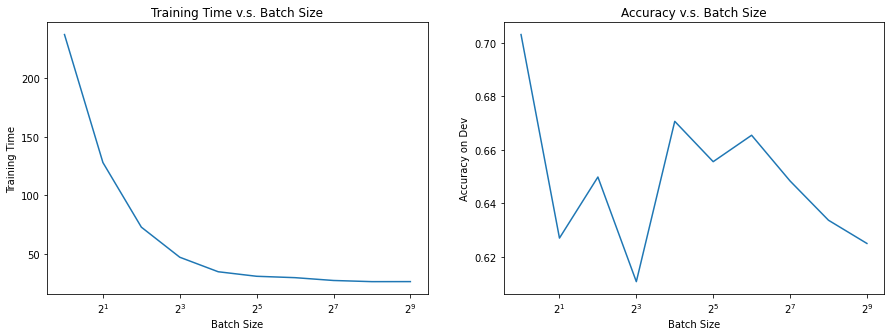

In [42]:
from matplotlib import pyplot as plt

batch_fig, axes = plt.subplots(1, 2, figsize=(15, 5))
time_vs_batch_ax, accu_vs_batch_ax = axes[0], axes[1]

# Plot the comparison between training time and batch size
time_vs_batch_ax.set_xscale("log", basex=2)
time_vs_batch_ax.set_xlabel("Batch Size")
time_vs_batch_ax.set_ylabel("Training Time")
time_vs_batch_ax.set_title("Training Time v.s. Batch Size")
time_vs_batch_ax.plot(batch_sizes, train_times)

# Plot the comparison between Dev set accuracy and batch size
accu_vs_batch_ax.set_xscale("log", basex=2)
accu_vs_batch_ax.set_xlabel("Batch Size")
accu_vs_batch_ax.set_ylabel("Accuracy on Dev")
accu_vs_batch_ax.set_title("Accuracy v.s. Batch Size")
accu_vs_batch_ax.plot(batch_sizes, valid_accus)

batch_fig.savefig("batch_fig.jpg")

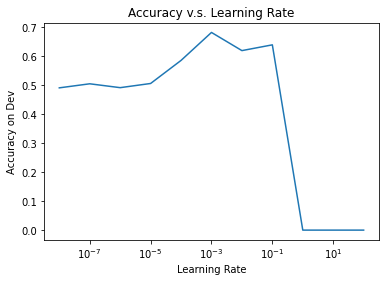

In [43]:
# Plot the comparison between Dev set accuracy and learning rate
lr_fig, accu_vs_lr_ax = plt.subplots()
accu_vs_lr_ax.set_xscale("log")
accu_vs_lr_ax.set_xlabel("Learning Rate")
accu_vs_lr_ax.set_ylabel("Accuracy on Dev")
accu_vs_lr_ax.set_title("Accuracy v.s. Learning Rate")
accu_vs_lr_ax.plot(learning_rates, lr_tuning_valid_accus)

lr_fig.savefig("lr_fig.jpg")

In [45]:
model, _, best_valid_accu = experiment(
    all_train_data,
    all_train_data,
    learning_rate=best_lr,
    batch_size=best_batch_size,
    num_epoch=5,
    name=f"best",
)

Training...:   2%|▏         | 2/98 [00:00<00:07, 13.06it/s]

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.025 | Train Acc: 53.58%
	 Val. Loss: 0.024 |  Val. Acc: 55.03%


Training...:   2%|▏         | 2/98 [00:00<00:07, 13.27it/s]

Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.020 | Train Acc: 58.03%
	 Val. Loss: 0.016 |  Val. Acc: 61.41%


Training...:   2%|▏         | 2/98 [00:00<00:08, 11.61it/s]

Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.018 | Train Acc: 59.43%
	 Val. Loss: 0.017 |  Val. Acc: 60.65%


Training...:   2%|▏         | 2/98 [00:00<00:06, 13.85it/s]

Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.018 | Train Acc: 59.72%
	 Val. Loss: 0.013 |  Val. Acc: 64.80%


Training...: 100%|██████████| 98/98 [00:07<00:00, 13.60it/s]


Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.017 | Train Acc: 61.11%
	 Val. Loss: 0.015 |  Val. Acc: 62.70%


In [91]:
# load the best model and evaluate the test set
model.load_state_dict(torch.load("model-best.pt"))

test_loader = DataLoader(
    dataset=test_data, batch_size=4, collate_fn=collate_batch, shuffle=True
)
test_loss, test_acc = evaluate(model, criterion, dataloader=test_loader)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.798 | Test Acc: 64.39%


In [134]:
# for mapping indexes to seq/labels
def idx2word_seq(raw_indexes, dataset):
    batch_seq = []
    for idx in raw_indexes:
        batch_seq.append(" ".join(dataset.X[idx]))
    return batch_seq


def idx2labels(indexes):
    batch_seq = []
    for idx in indexes:
        batch_seq.append(output_vocab.lookup_word(idx))
    return batch_seq

In [159]:
# generate output for val set and test set with the best model

valid_text, valid_label, valid_correct = [], [], []
test_text, test_label, test_correct = [], [], []
for X, y,idx in valid_loader:
    predictions = model(X)
    rounded_preds = torch.round(torch.sigmoid(predictions.squeeze(1)))
    correct = rounded_preds == y.T
    valid_text += idx2word_seq(idx, test_data)
    valid_label += idx2labels(rounded_preds.int().squeeze().cpu().detach().numpy())
    valid_correct += [c.item() for c in correct]
    
for X, y, idx in test_loader:
    predictions = model(X)
    rounded_preds = torch.round(torch.sigmoid(predictions.squeeze(1)))
    correct = rounded_preds == y.T
    test_text += idx2word_seq(idx, test_data)
    test_label += idx2labels(rounded_preds.int().squeeze().cpu().detach().numpy())
    test_correct += [c.item() for c in correct]

In [163]:
import pandas as pd

# output the prediction results as csv files

lr_dev_pred_df = pd.DataFrame(data={
    "text": valid_text,
    "label": valid_label,
    "correctness": valid_correct
})

lr_test_pred_df = pd.DataFrame(data={
    "text": test_text,
    "label": test_label,
    "correctness": test_correct
})

In [162]:
lr_dev_pred_df.to_csv("logistic_regression_dev_output.csv", index=False)

In [164]:
lr_test_pred_df.to_csv("logistic_regression_test_output.csv", index=False)